# Task 3: Hypothesis Testing

This notebook performs A/B testing to assess whether significant risk differences exist across customer segments such as provinces, postal codes, and genders.

**Goals**:
- Validate or reject predefined hypotheses using statistical tests.
- Focus on metrics: Claim Frequency, Loss Ratio, Margin, Claim Severity.
- Use t-test, Mann-Whitney, and Chi-squared tests as appropriate.

### Load Data

In [ ]:
import pandas as pd
import numpy as np

# Load the cleaned DataFrame from EDA (or re-run EDA if needed)
df = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep='|',parse_dates=['TransactionMonth'])

# Derived metrics
df['LossRatio'] = np.where(df['TotalPremium'] > 0, df['TotalClaims'] / df['TotalPremium'], np.nan)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# View sample
df[['Province', 'Gender', 'LossRatio', 'Margin', 'HasClaim']].head()

## Step 1: Hypothesis H1 – Risk Differences Across Provinces

- **Null Hypothesis (H1)**: No difference in average Loss Ratio across provinces.
- **Metric**: LossRatio (continuous).
- **Test**: T-test or ANOVA (if more than two provinces).

In [5]:
# Group counts
province_counts = df['Province'].value_counts()
print(province_counts)

# Filter provinces with at least 30 policies
valid_provinces = province_counts[province_counts >= 30].index.tolist()
df_province = df[df['Province'].isin(valid_provinces)]

print("Filtered provinces:", valid_provinces)

Province
Gauteng          393865
Western Cape     170796
KwaZulu-Natal    169781
North West       143287
Mpumalanga        52718
Eastern Cape      30336
Limpopo           24836
Free State         8099
Northern Cape      6380
Name: count, dtype: int64
Filtered provinces: ['Gauteng', 'Western Cape', 'KwaZulu-Natal', 'North West', 'Mpumalanga', 'Eastern Cape', 'Limpopo', 'Free State', 'Northern Cape']


### Visualize Group Differences

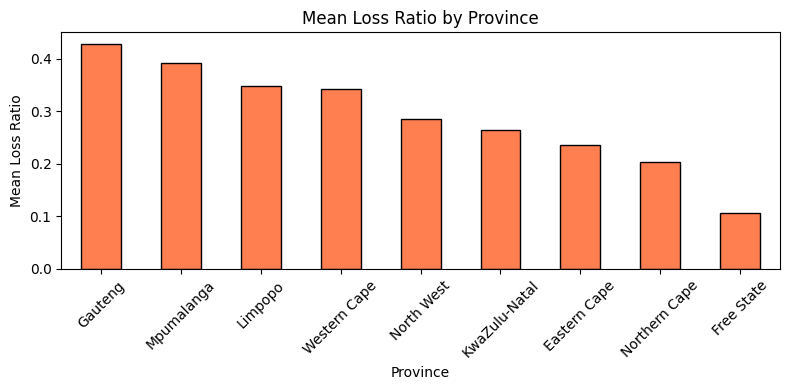

In [6]:
import matplotlib.pyplot as plt

# Mean LossRatio per province
loss_by_province = df_province.groupby('Province')['LossRatio'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(8, 4))
loss_by_province.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Mean Loss Ratio by Province')
plt.ylabel('Mean Loss Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Check Normality and Run Anova Test

In [7]:
from scipy.stats import f_oneway

# Group LossRatio arrays
groups = [group['LossRatio'].dropna() for name, group in df_province.groupby('Province') if len(group) >= 30]

# Run ANOVA (1-way)
stat, p_value = f_oneway(*groups)
print(f"ANOVA result: F-stat = {stat:.3f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Reject null hypothesis: significant difference in LossRatio across provinces.")
else:
    print("❌ Fail to reject null hypothesis: no significant difference found.")

ANOVA result: F-stat = 4.969, p-value = 0.0000
✅ Reject null hypothesis: significant difference in LossRatio across provinces.
